# Support Vector Machines and Neural Networks
We strongly recommend consulting the related exercises' jupyter notebooks and the referenced URLs when working on this task.

In [182]:
# set random seeds
import random

import matplotlib.pyplot as plt
import numpy as np
# Import Pandas and NumPy functionality for editing data
import pandas as pd
import seaborn as sns
# Importing IPython display for visualizing intermediate results in the notebook
from IPython.display import display

# data preparation
# classifiers
# evaluation

random.seed(42)
np.random.seed(42)


In [183]:
# general variables that may help you in the tasks
numeric_features = ["age", "trestbps", "chol", "thalch", "oldpeak"]
colors_target = {"healthy heart": "b", "heart condition": "r", 0: "b", 1: "r", 2: "g", 3: "y", 4: "m"}
markers_target = {"healthy heart": "o", "heart condition": "^", 2: "d", 3: "s", 4: "v", 0: "o", 1: "^", }
colors = ["blue", "red", "green", "yellow", "cyan"]
markers = ["o", "^", "d", "s", "v"]

### we recommend creating two datasets for the SVM and NN classifiers both with a column called "target" containing the target values. This allows you to make use of the following functions for both classifiers. You don"t need to use these functions, but they might appear useful to you.
### for the full data you use on the neural network, we recommend just renaming the column called "num" (df.rename(columns={"num": "target"}) 
### in the binary classifiers this target column should contain the values "healthy heart" and "heart condition" 
target_name = "target"
target = [target_name]

In [184]:
###### Potentially useful functions ######

# Pairplot for numeric features
def create_pairplot(data: pd.DataFrame, features: list = numeric_features, target_name: str = target_name,
                    markers: list = markers, name: str = None):
    markers = markers[:len(data[target_name].unique())]
    pairplot = sns.pairplot(data[features + [target_name]], hue=target_name, diag_kind="hist", markers=markers)
    if name:
        pairplot.fig.suptitle(f"Pairplot for {name}")
        pairplot.savefig(f"pairplot_{name}.png")

    display(pairplot)


# Bar Chart for values in selected column
def create_barchart_selected_column(training_data: pd.DataFrame, test_data: pd.DataFrame, column_name: str,
                                    name: str = None, relative_values: bool = True):
    for data_name, data in zip(('Training Data', 'Test Data'), (training_data, test_data)):

        class_counts = data[column_name].value_counts(normalize=relative_values)
        class_counts = class_counts.round(2)

        ax = class_counts.plot(kind="bar")

        for p in ax.patches:
            ax.annotate(f"{p.get_height()}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha="center", va="center",
                        xytext=(0, 10),
                        textcoords="offset points")

        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.title(f"Frequency of Instances per {column_name} in  {data_name}")

        # make xaxis labels horizontal
        plt.xticks(rotation=0)

        plt.tight_layout()
        if name:
            plt.savefig(f"hist_{name}_{data_name}.png")
        else:
            plt.savefig(f"hist_{data_name}.png")
        plt.show()


## Create 3D scatter plot
def create_3d_scatter(data: pd.DataFrame, x_column: str, y_column: str, z_column: str, target_name: str = target_name,
                      colors: dict = colors_target, markers: dict = markers_target, name: str = None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in data[target_name].unique():
        class_data = data[data[target_name] == target_class]
        ax.scatter(class_data[x_column], class_data[y_column], class_data[z_column],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Set labels
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_zlabel(z_column)

    # Set title
    ax.set_title(f"3D Scatter Plot: {x_column}, {y_column}, {z_column}")

    if name:
        plt.savefig(f"3d_scatter_{name}_{x_column}_{y_column}_{z_column}.png")

    # Show plot
    plt.show()


## results grid search
def compare_results_grid_search(grid_object, run_name: str):
    results = pd.DataFrame(grid_object.cv_results_)

    plt.figure(figsize=(10, 8))

    colors_setting = {"linear": "r", "rbf": "y", "sigmoid": "g", "poly": "b"}
    markers_setting = {"linear": "o", "rbf": "^", "sigmoid": "s", "poly": "x"}

    for kernel in results["param_kernel"].unique():
        kernel_data = results[results["param_kernel"] == kernel]
        plt.scatter(kernel_data["param_C"], kernel_data["mean_test_score"],
                    label=kernel, marker=markers_setting[kernel], color=colors_setting[kernel])

    plt.xlabel("Regularization Parameter (C)")
    plt.ylabel("Accuracy")
    plt.title("Grid Search Results")
    plt.legend(title="Kernel")

    if run_name:
        plt.savefig(f"grid_search_results_{run_name}.png")

    plt.show()

### SVMs: Load, prepare and visualize data
We recommend resetting the index and dropping the _id_ column.
To help you set up a sensible data structure, we kept the cells with comments on what we did here to create a possible solution to the first subtask. 

In [185]:
# load the data 
df_train = pd.read_csv("../heart_disease_data/train_dataset.csv")
df_test = pd.read_csv("../heart_disease_data/test-dataset-oh.csv")

In [186]:
# prepare the full data sets for binary classifier & drop old target
columns = df_test.columns
df_train.reset_index()
df_test.reset_index()

df_train_str_target = df_train["num"].copy()
df_test_str_target = df_test["num"].copy()
df_train_str_target[df_train_str_target!=0] = "heart condition"
df_train_str_target[df_train_str_target==0] = "healthy heart"
df_test_str_target[df_test_str_target!=0] = "heart condition"
df_test_str_target[df_test_str_target==0] = "healthy heart"

print(df_train_str_target)

# drop num column
df_train_feature = df_train.copy().drop("num",axis='columns')
df_test_feature = df_test.copy().drop("num",axis='columns')



0        healthy heart
1        healthy heart
2      heart condition
3      heart condition
4      heart condition
            ...       
685      healthy heart
686    heart condition
687      healthy heart
688    heart condition
689    heart condition
Name: num, Length: 690, dtype: object


C:\Users\finnv\AppData\Local\Temp\ipykernel_22720\610953894.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_str_target[df_train_str_target!=0] = "heart condition"
C:\Users\finnv\AppData\Local\Temp\ipykernel_22720\610953894.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_str_target[df_test_str_target!=0] = "heart condition"


In [187]:
# prepare the full data sets for nn classifier & rename target
df_train_ord_target = df_train["num"].copy()
df_test_ord_target = df_test["num"].copy()

In [188]:
# create new dataframes with only the descriptive feature matrices (X) and the target feature vectors (y) for both the training and test data. The descriptive feature matrix is the same for both the SVM and the NN classifier.


# descr. feature matrices (train & test)
x_train = df_train_feature.to_numpy(dtype=np.float64)
x_test = df_test_feature.to_numpy(dtype=np.float64)


# target feature vectors binary classifier
y_train_bin = df_train_str_target.to_numpy(dtype=str)
y_test_bin = df_test_str_target.to_numpy(dtype=str)

# target feature vectors severity classifier (Neural Network)
y_train_nn = df_train_ord_target.to_numpy(dtype=np.float64)
y_test_nn = df_test_ord_target.to_numpy(dtype=np.float64)


### Data Exploration & Visualization
#### Severity Classification: Distribution of Heart Conditions

In [189]:
# For those among you who are curious: A function to create a 3D scatterplot depicting the hyperplane ;)

def plot_3d_hyperplane(svm_classifier, training_data: pd.DataFrame, target_name: str, colors=colors_target,
                       markers=markers_target, name: str = None):
    # Extract the coefficients and intercept
    weights = svm_classifier.coef_[0]
    intercept = svm_classifier.intercept_[0]
    feature_order = svm_classifier.feature_names_in_

    # Create a mesh grid for the 3D space
    xx, yy = np.meshgrid(
        np.linspace(training_data[feature_order[0]].min(), training_data[feature_order[0]].max(), 50),
        np.linspace(training_data[feature_order[1]].min(), training_data[feature_order[1]].max(), 50))

    # Calculate the decision boundary (hyperplane)
    zz = (-weights[0] * xx - weights[1] * yy - intercept) / weights[2]

    # Plot the 3D scatter plot and the hyperplane
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in training_data[target_name].unique():
        class_data = training_data[training_data[target_name] == target_class]
        ax.scatter(class_data[feature_order[0]], class_data[feature_order[1]], class_data[feature_order[2]],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Plot the hyperplane
    ax.plot_surface(xx, yy, zz, color="yellow", alpha=0.2)

    # Set labels
    ax.set_xlabel(feature_order[0])
    ax.set_ylabel(feature_order[1])
    ax.set_zlabel(feature_order[2])

    # Set title
    ax.set_title(
        f"3D Scatter Plot with SVM Hyperplane, {feature_order[0]}, {feature_order[1]}, {feature_order[2]}")

    # Add legend
    ax.legend()
    if name:
        plt.savefig(f"3d_scatter_{name}_plane.png")
    else:
        pass
    # Show plot
    plt.show()

#### Severity Classifier Target Exploration

<Axes: ylabel='Density'>

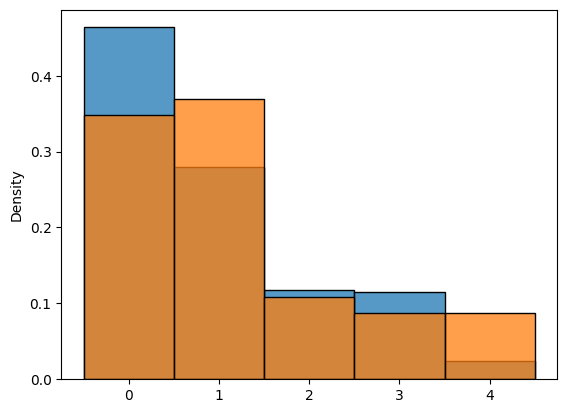

In [190]:

fig, ax = plt.subplots()
sns.histplot(y_train_nn, stat="density", discrete=True, common_norm=False,ax=ax)
sns.histplot(y_test_nn, stat="density", discrete=True, common_norm=False,ax=ax)


#### Binary Classifier: 3D and 2D Feature Visualization
Select three features.

In [191]:
selected_features = ...


### Grid search for configuration
Train binary classifiers using only the three selected features as descriptive features.

For this question, we recommend taking a look at the method "cv_results" of the grid search object: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [192]:
grid_params_selected_features = {
    "C": [0.1, 10, 50, 100, 500],
    "kernel": ["linear", "rbf", "poly"],
}

### Baseline Models
Both classifier types are trained using all features.

#### SVMs: Base Binary Classifier

#### Neural Network: Base Classifier

### Feature Engineering

In [193]:
def deviation_mean(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                   target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training and test data as well as a list of features you want to transform. Function returns test and training data lifted to the higher dimension by dividing each of the passed feature names' values by the trainings data's mean."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## add you code here
    ...

    return training_data_transformed, test_data_transformed


def scale_zero(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
               target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed feature names are scaled around zero."""
    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## add you code here
    ...

    return training_data_transformed, test_data_transformed


def normalize_features(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                       target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed features are normalized according to the value's ranges."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## add you code here
    ...

    return training_data_transformed, test_data_transformed


### Neural Network Structure
First, only consider the training data. Then, in the next subtask, consider the test data as well.

### Good SVM Classifier
Perform some educated trial and error to try and find a good SVM classifier.